# Find the QPO peaks in a dynamical power spectrum from kHz_dyn_psd.ipynb or dyn_psds.py

In [1]:
import numpy as np
from astropy.table import Table, Column
from astropy.io import fits
import os
import subprocess
import fileinput
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator
# import scipy.spatial as spatial
%matplotlib inline
from xcor import find_nearest

## Load a table `tab` of the linearly re-binned dynamical power spectrum.
This was created from toy_kHz_longer_lightcurve.fits.

In [2]:
homedir = os.path.expanduser("~")
cwd = os.getcwd()
print(cwd)
nsec = 32
bins = 4096
table_file = cwd+"/dynpsd_5PCUs_%dsec_%drb.fits" % (nsec, bins)
flx2xsp_cmd_file = cwd+"/peakfinding_5PCUs_%dsec_%drb_flx2xsp.sh" % (nsec, bins)
out_file = cwd+"/peakfinding_5PCUs_%dsec_%drb.txt" % (nsec, bins)
tab = Table.read(table_file)
print(tab.info)
print(tab.meta)

/Users/abbie/Documents/GitHub/gsoc18
<Table length=4096>
   name    dtype  shape  unit
--------- ------- ------ ----
FREQUENCY float64          Hz
      PSD float64 (195,)     

OrderedDict([('OBJECT', '4U 1608-52'), ('OBS_ID', '10072-05-01-00'), ('INST', 'RXTE'), ('N_SEG', 195), ('N_SEC', 32.0), ('OLD_NBIN', 262144), ('OLD_DF', 0.03125), ('NEW_NBIN', 4096), ('NEW_DF', 0.9999923706054688), ('EXPOSURE', 6240.0), ('DT', 0.0001220703125)])


## Plot that dynamical power spectrum, so we can see where to set the fit boundaries for the peaks and what starting value to give the normalizations.

In [3]:
init_peak = np.concatenate((np.tile(851,15), np.tile(848, 15), np.tile(852,5), np.tile(834, 5), np.tile(830, 5), np.tile(827, 10), np.tile(823, 7), np.tile(829,3), np.tile(833, 14), np.tile(830, 17), np.tile(828, 4), np.tile(826,5), np.tile(828,10), np.tile(831,4), np.tile(826,2), np.tile(824, 2), np.tile(828,3), np.tile(830, 4), np.tile(828,1),np.tile(824,2), np.tile(827,1), np.tile(831,2), np.tile(833,5), np.tile(837,1), np.tile(830,1),np.tile(834,9), np.tile(835, 4), np.tile(837,5), np.tile(840,1), np.tile(843,1),np.tile(840,8), np.tile(836,5), np.tile(834,6), np.tile(832,3), np.tile(830,1), np.tile(827,2), np.tile(830,1), np.tile(832,1), np.tile(835,1), np.tile(837,3), np.tile(838,1)), axis=0)
print(len(init_peak))
segs = np.arange(len(init_peak))+.4

195


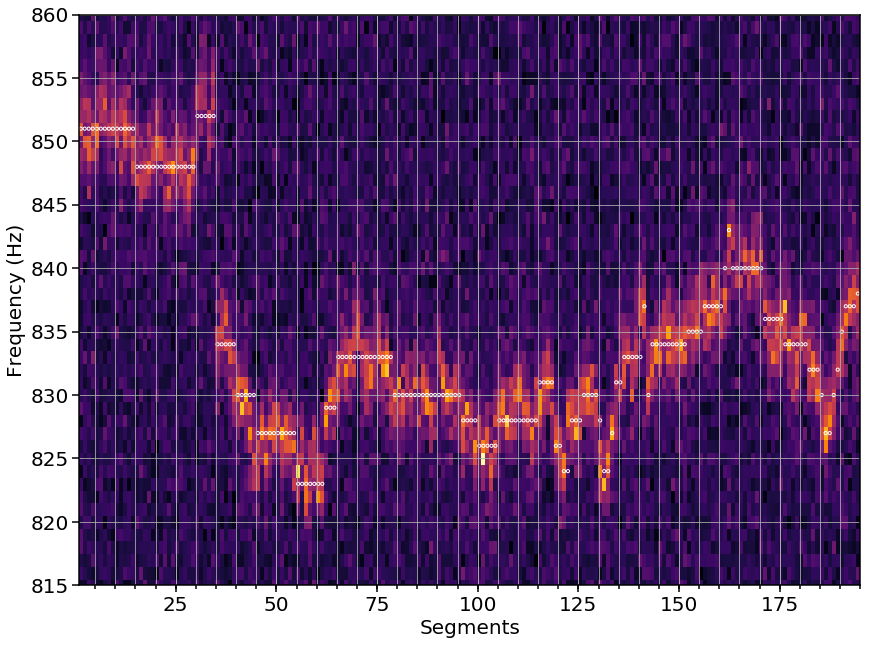

In [4]:
# %matplotlib notebook
seg_num = np.arange(0, tab.meta['N_SEG']+1, dtype=int)
seg_sec = np.arange(0, tab.meta['EXPOSURE'], tab.meta['N_SEC'], dtype=int)
lf = int(find_nearest(tab['FREQUENCY'], 815)[1])
uf = int(find_nearest(tab['FREQUENCY'], 860)[1])

font_prop = font_manager.FontProperties(size=20)
fig, ax = plt.subplots(1, 1, figsize=(14, 10.5),)

plt.pcolor(seg_num, tab['FREQUENCY'][lf-1:uf+1], tab['PSD'][lf-1:uf+1,:], cmap='inferno')
ax.scatter(segs, init_peak, marker='o', s=10., edgecolors='white', facecolors='none')

# cbar = plt.colorbar()
# cb_ax = cbar.ax
# cbar.set_label(r'PSD amplitude (Leahy norm.)', 
#                fontproperties=font_prop)
# cb_ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('Frequency (Hz)', fontproperties=font_prop)
ax.set_ylim(815, 860)
ax.set_xlim(1, tab.meta['N_SEG'])
ax.set_xlabel('Segments', fontproperties=font_prop)

## Setting the axes' minor ticks. It's complicated.
x_maj_loc = ax.get_xticks()
x_min_mult = 0.2 * (x_maj_loc[1] - x_maj_loc[0])
xLocator = MultipleLocator(x_min_mult)  ## loc of minor ticks on x-axis
ax.xaxis.set_minor_locator(xLocator)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.xaxis.grid(True, which='both')
ax.yaxis.grid()
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.show()

## We're only interested in fitting the dynamical PSDs between 750 and 950 Hz based on the above plot, so find those bounds.

In [5]:
lb = int(find_nearest(tab['FREQUENCY'], 750)[1])  # index of frequency closest to 750 Hz
ub = int(find_nearest(tab['FREQUENCY'], 950)[1])  # index of frequency closest to 950 Hz

## Below I'm doing the fitting in XSPEC. You should do this with the stingray power spectra fitting!
Make the .txt table to feed into the FTOOLS command flx2xsp. I'm putting in a fake error here.

In [7]:
freq_min = tab['FREQUENCY'][lb:ub]-(0.5*tab.meta['NEW_DF'])
freq_max = tab['FREQUENCY'][lb:ub]+(0.5*tab.meta['NEW_DF'])
psd_df = tab['PSD'][lb:ub,:] * tab.meta['NEW_DF']
print(np.shape(psd_df))
out_tab_df = np.concatenate((freq_min[:,np.newaxis], freq_max[:,np.newaxis]), axis=1)
## Assuming a 15% error in the power spectrum
fake_err = tab['PSD'][lb:ub,:] * 0.15 * tab.meta['NEW_DF']
for i in range(tab.meta['N_SEG']):
#     print(np.shape(psd_df[:,i][:,np.newaxis]))
#     print(np.shape(err[:,np.newaxis]))
    out_tab_df = np.concatenate((out_tab_df, psd_df[:,i][:,np.newaxis], fake_err[:,i][:,np.newaxis]), axis=1)
print(np.shape(out_tab_df))
np.savetxt(out_file, out_tab_df)

(200, 195)
(200, 392)


## Print what needs to be run for flx2xsp, so we can copy/paste into the command line.

In [4]:
basename = os.path.basename(out_file)[:-4]
print("heainit")
print("cd %s/Dropbox/Research/kHz_QPO_phase_res/out_dynpsd" % homedir)
print("flx2xsp %s.txt %s.pha %s.rsp nspec=%d clobber=yes" % (basename, basename, 
                                                                        basename, tab.meta['N_SEG']))


heainit
cd /Users/abigail/Dropbox/Research/kHz_QPO_phase_res/out_dynpsd
flx2xsp peakfinding_5PCUs_32sec_4096rb.txt peakfinding_5PCUs_32sec_4096rb.pha peakfinding_5PCUs_32sec_4096rb.rsp nspec=195 clobber=yes


## Write the XSPEC fitting script. Using a very simple model: pow+lor.
The power law slope is fixed to 0 since it should be Poisson noise, and the normalization of the power law is bounded around 2 since these power spectra are Leahy-normalized. The peak of the Lorentzian (kHz QPO) is bounded within 20 Hz of the apparent approximate peak from the above dynamical psd plot, the FWHM of the Lorentzian is loosely bounded and tied among all the segments (with the assumption being that it's the same QPO, so same width, just moving in frequency), and the normaliation of the Lorentzian is free and unbounded.
We also make two plots; one is the fitted power spectra, and the other is the ratio plot (don't want a big bump at the kHz QPO frequency).

In [5]:
# extra = "_sigma-tied-norm-tied_"
extra = "_sigma-tied-norm-free_"
# extra = "_"
xspec_fit_script = "./out_dynpsd/"+basename+extra+"fitcmd.xcm"
## need +1 in these loop limits because starting at 1
n_spec = tab.meta['N_SEG']
with open(xspec_fit_script, mode='w') as out:
    out.write("data ")
    for j in range(1,n_spec+1):  
        out.write("%d:%d %s.pha{%d} " % (j,j,basename,j))
    out.write("\nsetplot energy \n")
    out.write("mod pow+lor")
    for i in range(1,n_spec+1):
        out.write("& 0 -1 & 2 .1 1.1 1.1 2.5 2.5 "+
#                   "& %d 1 %d %d %d %d &  & 15" % (init_peak[i-1], init_peak[i-1]-8, init_peak[i-1]-8, init_peak[i-1]+8, init_peak[i-1]+8))
                  "& %d -1 &  & 15" % (init_peak[i-1]))
 ## Remember that these are 1-indexed!
            
    out.write("\nchatter 4 \n")
    out.write("newpar 4 5 0.1 1 1 10 10 \n")
#     out.write("newpar 5 15 \n")
    out.write("query no \n")
    out.write("log %s%sfit.log \n" % (basename, extra))
    out.write("fit 1000 \n")
    for (i,j) in zip(range(3, 975, 5), range(0,n_spec)):
        out.write("newpar %d %.0f 1 %d %d %d %d \n" % (i, init_peak[j], init_peak[j]-8, init_peak[j]-8, init_peak[j]+8, init_peak[j]+8))
    out.write("fit 500 \n")
    out.write("save all %s%sall.xcm \n" % (basename, extra))
    out.write("y \n")
    out.write("save mod %s%smod.xcm \n" % (basename, extra))
    out.write("y \n")
    out.write("newpar 0 \n")
    out.write("cpd /ps \n")
    out.write("setplot delete all \n")
    out.write("setplot command la T Fitting kHz QPO peaks\n")
    out.write("setplot command la x Frequency (Hz) \n")
    out.write("setplot command la y Power (Leahy) \n")
    out.write("setplot command cs 1.3 \n")
    out.write("setplot command ma size 3\n")
    out.write("setplot command lw 4 \n")
    out.write("setplot command log x off \n")
    out.write("setplot command log y off \n")
    out.write("setplot command hardcopy %s%sfit.eps/cps \n" % (basename, extra))
    out.write("plo ufspec \n")
    out.write("setplot delete all \n")
    out.write("setplot command cs 1.3 \n")
    out.write("setplot command ma size 3\n")
    out.write("setplot command lw 4 \n")
    out.write("setplot command la T data/model\n")
    out.write("setplot command la x Frequency (Hz) \n")
    out.write("setplot command log x off \n")
    out.write("setplot command hardcopy %s%sratio.eps/cps \n" % (basename, extra))
    out.write("plo ratio \n")
    out.write("quit \n")

## Printing what needs to be run in the command line. Copy/paste!

In [6]:
print("xspec %s > dump.txt " % os.path.basename(xspec_fit_script))
print("xspec < %s " % os.path.basename(xspec_fit_script))

# p = subprocess.Popen("heainit", shell=True)  
# p = subprocess.Popen("xspec %s > %s" % (os.path.basename(xspec_fit_script), "./out_dynpsd/dump.txt"), shell=True)  
# ## Setting shell=True allows you to run non-standard shell commands, and Popen lets us redirect the output
# p.communicate()  ## Waits for the command to finish running.

xspec peakfinding_5PCUs_32sec_4096rb_sigma-tied-norm-free_fitcmd.xcm > dump.txt 
xspec < peakfinding_5PCUs_32sec_4096rb_sigma-tied-norm-free_fitcmd.xcm 


## Once that's done, read in the model file to get the parameter values.
Need to replace `=p4` with placeholder FWHM values so that I can read the whole table in as a numpy array with `np.loadtxt`.

In [7]:
model_file = "./out_dynpsd/%s%smod.xcm" % (basename, extra)
print("Reading in from: "+model_file)

## Thanks StackOverflow!
## https://stackoverflow.com/questions/17140886/how-to-search-and-replace-text-in-a-file-using-python
with fileinput.FileInput(model_file, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("= p4", "\t\t5.45435        0.1          1          1         10         10"), end='')

Reading in from: ./out_dynpsd/peakfinding_5PCUs_32sec_4096rb_sigma-tied-norm-free_mod.xcm


## Read in the table, make arrays for the indices of each type of parameter, and print the peak frequencies.

In [8]:
intab = np.loadtxt(model_file, skiprows=7)
assert np.shape(intab)[0] == tab.meta['N_SEG'] * 5
ind_noise_norm = np.arange(1, 975, 5)
ind_peaks = np.arange(2, 975, 5)
ind_qpo_norm = np.arange(4, 975, 5)
noise_norm = intab[ind_noise_norm,0]
peaks = intab[ind_peaks,0]
qpo_norm = intab[ind_qpo_norm,0]
print(peaks)

[ 849.725  851.111  850.747  850.201  850.897  851.226  854.059  853.012
  850.681  850.549  850.149  849.039  851.107  850.942  849.859  848.892
  846.801  848.409  848.861  848.526  849.377  849.817  847.031  846.285
  847.898  849.597  847.22   845.377  846.382  848.395  849.979  853.356
  853.992  850.36   852.412  833.221  833.374  836.138  833.272  830.77
  829.663  828.079  829.251  826.453  823.453  823.521  828.401  824.981
  827.647  826.393  826.865  825.303  826.968  827.909  827.59   822.958
  825.274  821.887  823.374  823.854  824.13   823.484  827.612  830.427
  829.862  831.667  832.752  832.529  831.618  835.627  836.631  832.187
  831.398  830.743  833.566  833.235  832.409  831.414  829.178  829.316
  830.805  828.936  832.188  830.091  831.521  827.607  831.59   830.048
  827.904  829.274  832.621  830.489  829.521  828.145  830.089  829.808
  826.564  828.447  826.835  825.059  826.102  824.039  825.782  823.487
  826.263  827.703  828.167  828.294  829.64   828.7

In [9]:
print(noise_norm)

[ 2.0151   1.97875  1.93802  1.95057  1.97714  1.97501  1.99703  1.96221
  2.02418  2.01935  1.89936  2.02221  1.98781  1.97272  1.97178  1.95098
  2.01432  1.98434  1.96926  1.97177  1.94059  1.95234  2.02279  1.99011
  1.96618  1.96971  1.96564  1.98455  1.97015  1.98226  1.99608  1.95092
  1.98789  1.9885   1.96659  2.00278  1.98016  1.98497  1.95988  1.99287
  2.0142   1.97727  1.96198  1.98163  1.97207  2.03871  1.94803  2.0277
  1.97756  1.93555  1.92833  1.98099  1.94694  1.98644  2.01901  1.98355
  2.0087   1.97136  1.99129  1.96303  1.94391  1.9914   1.96261  2.01096
  1.98503  2.0083   1.97634  1.9876   1.93823  2.01469  1.94525  2.03241
  1.98801  2.01275  1.98896  1.90638  2.00179  2.00485  1.98612  2.01981
  2.00602  1.98826  1.95397  1.99845  1.99911  1.97595  1.95965  1.98383
  1.96161  1.94823  1.99997  1.91734  1.98794  1.99137  1.98057  1.98592
  1.95701  1.97594  2.02242  1.90471  1.96812  1.99189  1.97939  1.94226
  1.9797   1.95074  1.9463   2.00497  2.02248  1.976

Printing out some info about the peaks

In [10]:
print(np.argmin(peaks))
print(np.min(peaks))
print(np.argmax(peaks))
print(np.max(peaks))

57
821.887
6
854.059


## Plot the dynamical power spectrum again, with white circles at the fitted peaks, and cyan circles at the peaks that hit the bounds.

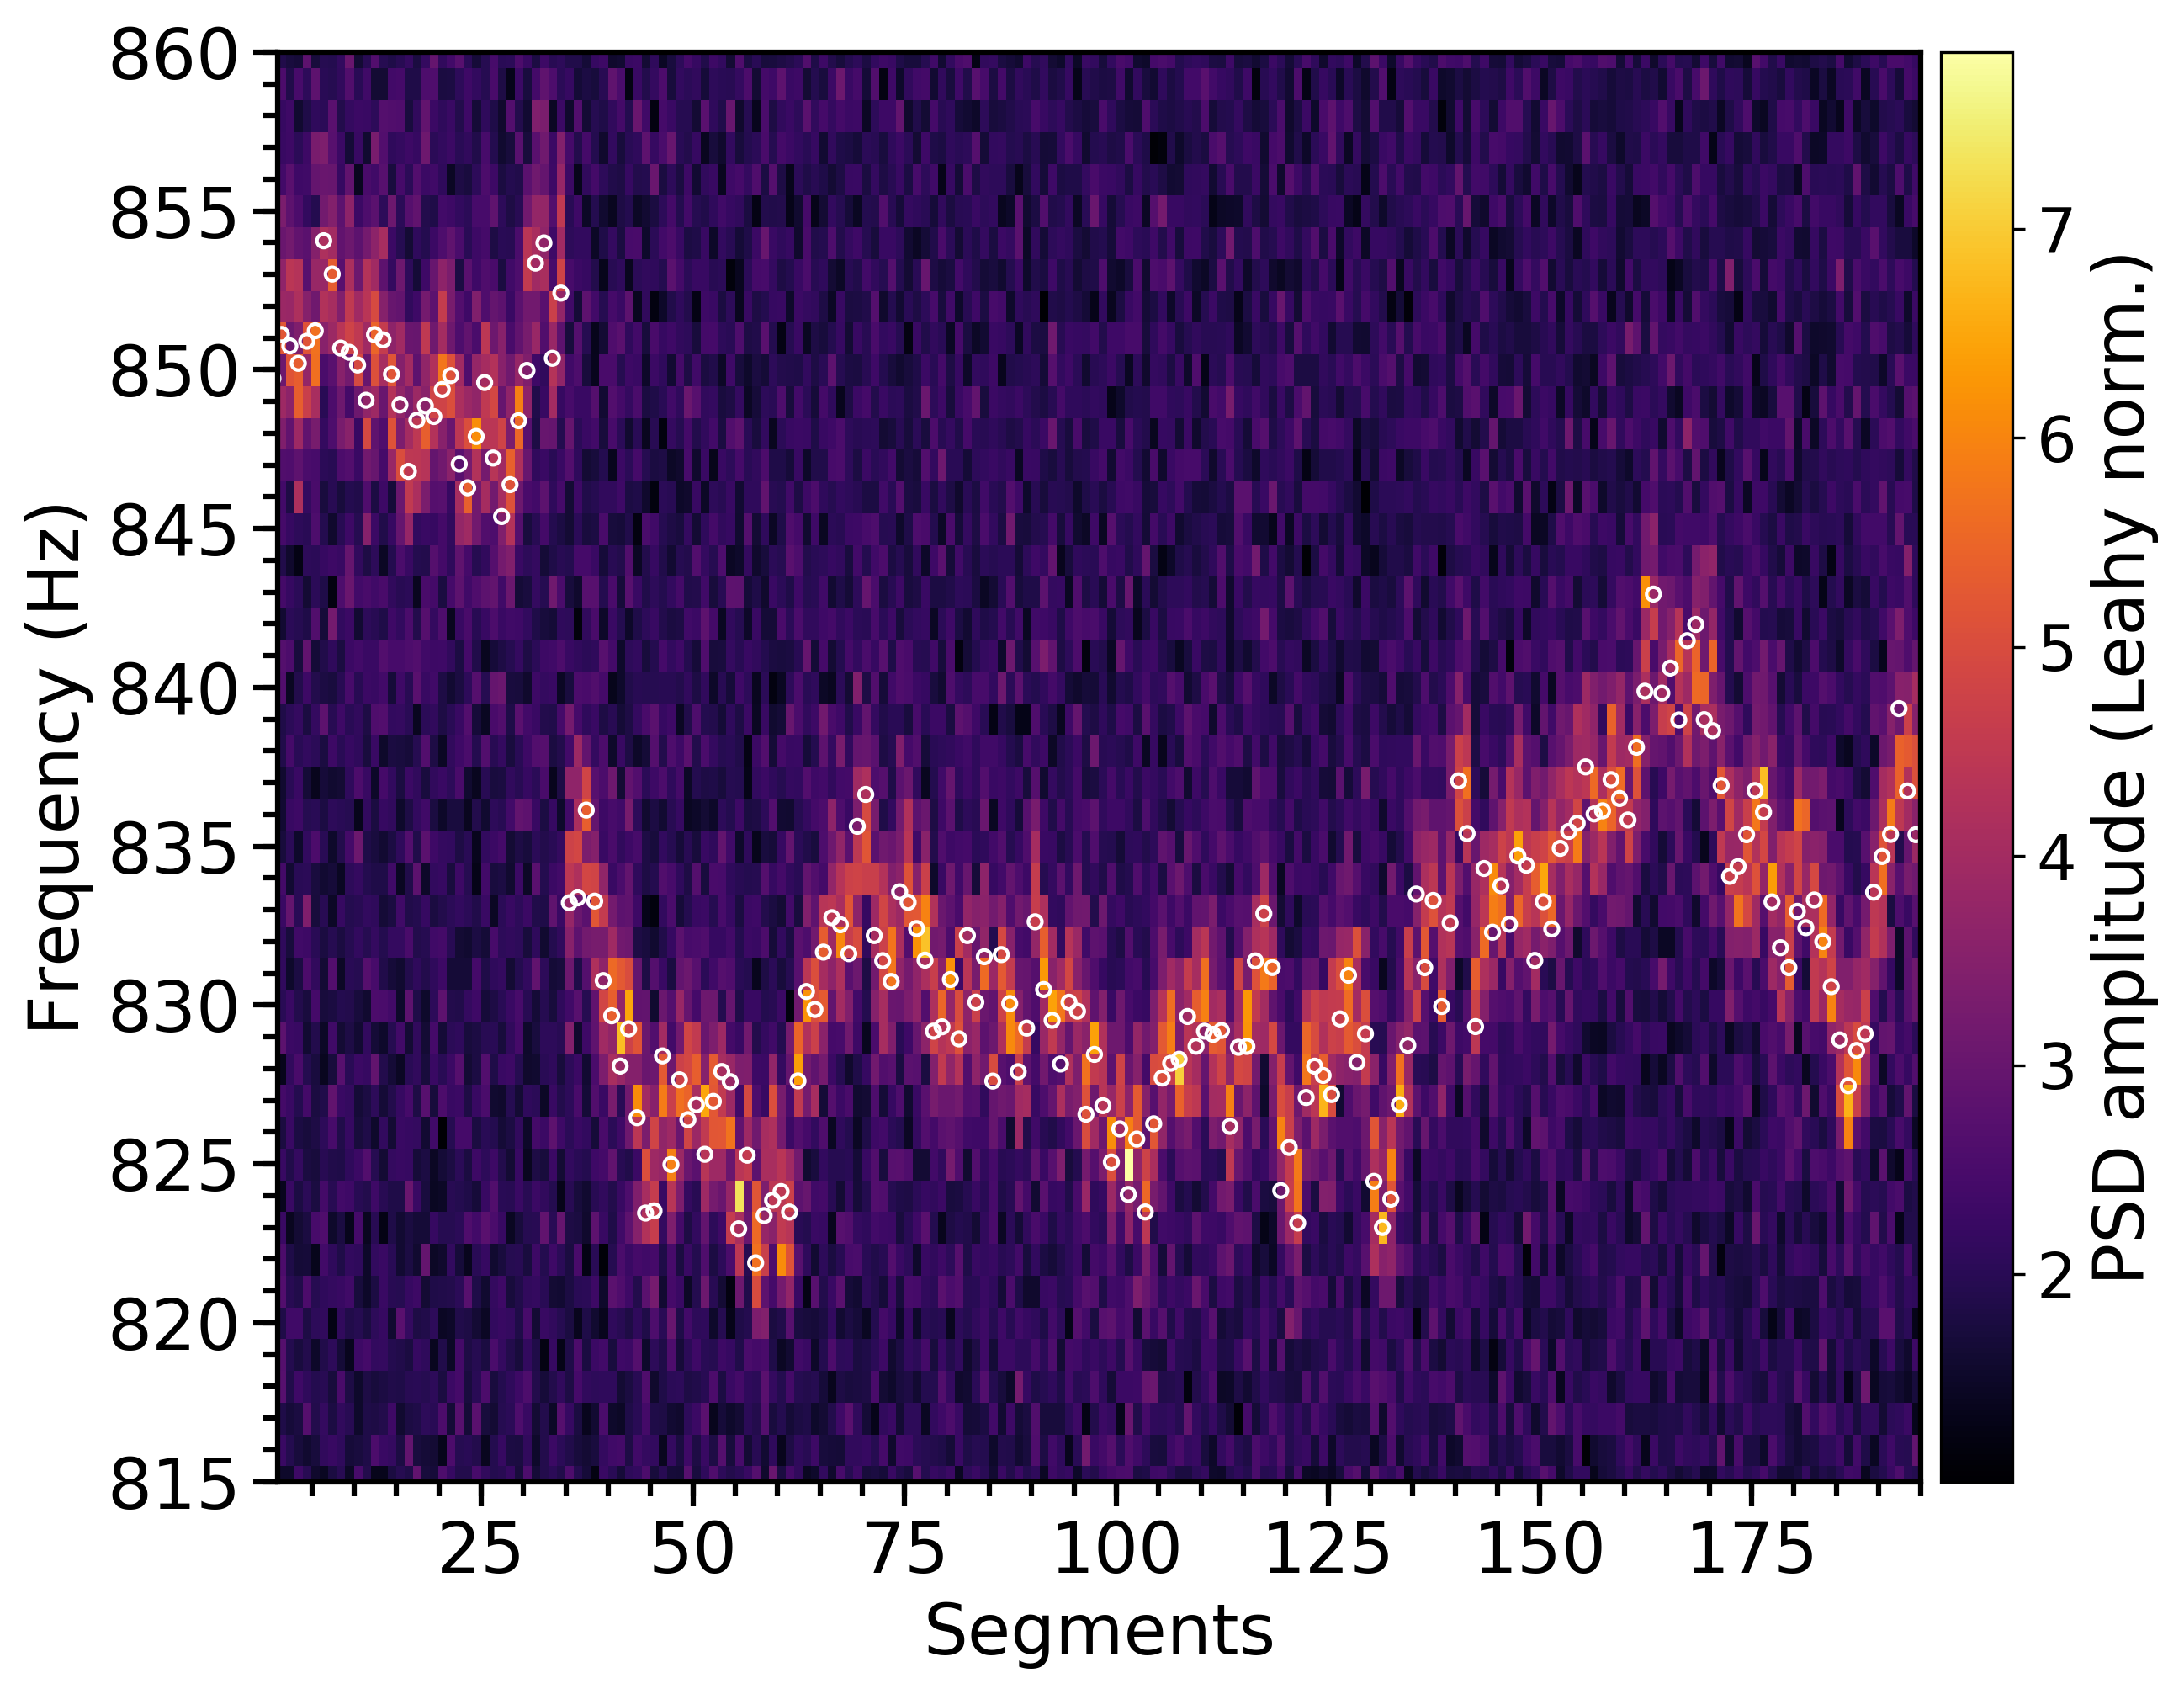

In [11]:
%matplotlib inline
seg_num = np.arange(0, tab.meta['N_SEG']+1, dtype=int)
seg_sec = np.arange(0, tab.meta['EXPOSURE'], tab.meta['N_SEC'], dtype=int)
lf = int(find_nearest(tab['FREQUENCY'], 815)[1])
uf = int(find_nearest(tab['FREQUENCY'], 860)[1])

font_prop = font_manager.FontProperties(size=20)
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5), dpi=300)
# fig, ax = plt.subplots(1, 1, figsize=(14, 10.5))

plt.pcolor(seg_num, tab['FREQUENCY'][lf-1:uf+1], tab['PSD'][lf-1:uf+1,:], cmap='inferno')
ax.scatter(seg_num[0:-1]+0.4, peaks, marker='o', s=15., edgecolors='white', facecolors='none')
# cursor = FollowDotCursor(ax, seg_num[0:-1], peaks)
cbar = plt.colorbar(pad=0.01)
cbar.set_label(r'PSD amplitude (Leahy norm.)', 
               fontproperties=font_prop)
cb_ax = cbar.ax
cb_ax.tick_params(axis='y', labelsize=18)
# cbar.set_ticks([-0.04, -0.03, -0.02, -0.01, 0.00, 0.01, 0.02, 0.03, 0.04])
ax.set_ylabel('Frequency (Hz)', fontproperties=font_prop)
ax.set_ylim(815, 860)
ax.set_xlim(1, tab.meta['N_SEG'])
ax.set_xlabel('Segments', fontproperties=font_prop)

## Setting the axes' minor ticks. It's complicated.
# x_maj_loc = ax.get_xticks()
# x_min_mult = 0.2 * (x_maj_loc[1] - x_maj_loc[0])
xLocator = MultipleLocator(5)  ## loc of minor ticks on x-axis
yLocator = MultipleLocator(1)  ## loc of minor ticks on y-axis
ax.xaxis.set_major_locator(MultipleLocator(25))
ax.xaxis.set_minor_locator(xLocator)
ax.yaxis.set_minor_locator(yLocator)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
# ax.xaxis.grid(True, which='both')
# ax.yaxis.grid()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.savefig("./out_dynpsd/%s_peaks.png" % basename, dpi=300)
plt.show()

## Saving the peaks to a file

In [58]:
np.savetxt("./out_dynpsd/%s_frequencies.txt" % basename, peaks, fmt="%.3f")

In [ ]:
## Never got this to work.

def fmt(x, y):
    return 'x: {x:0.2f}\ny: {y:0.2f}'.format(x=x, y=y)

class FollowDotCursor(object):
    """Display the x,y location of the nearest data point."""
    def __init__(self, ax, x, y, tolerance=5, formatter=fmt, offsets=(-20, 20)):
        try:
            x = np.asarray(x, dtype='float')
        except (TypeError, ValueError):
            x = np.asarray(mdates.date2num(x), dtype='float')
        y = np.asarray(y, dtype='float')
        self._points = np.column_stack((x, y))
        self.offsets = offsets
        self.scale = x.ptp()
        self.scale = y.ptp() / self.scale if self.scale else 1
        self.tree = spatial.cKDTree(self.scaled(self._points))
        self.formatter = formatter
        self.tolerance = tolerance
        self.ax = ax
        self.fig = ax.figure
        self.ax.xaxis.set_label_position('top')
        self.dot = ax.scatter(
            [x.min()], [y.min()], s=130, color='green', alpha=0.7)
        self.annotation = self.setup_annotation()
        plt.connect('motion_notify_event', self)

    def scaled(self, points):
        points = np.asarray(points)
        return points * (self.scale, 1)

    def __call__(self, event):
        ax = self.ax
        # event.inaxes is always the current axis. If you use twinx, ax could be
        # a different axis.
        if event.inaxes == ax:
            x, y = event.xdata, event.ydata
        elif event.inaxes is None:
            return
        else:
            inv = ax.transData.inverted()
            x, y = inv.transform([(event.x, event.y)]).ravel()
        annotation = self.annotation
        x, y = self.snap(x, y)
        annotation.xy = x, y
        annotation.set_text(self.formatter(x, y))
        self.dot.set_offsets((x, y))
        bbox = ax.viewLim
        event.canvas.draw()

    def setup_annotation(self):
        """Draw and hide the annotation box."""
        annotation = self.ax.annotate(
            '', xy=(0, 0), ha = 'right',
            xytext = self.offsets, textcoords = 'offset points', va = 'bottom',
            bbox = dict(
                boxstyle='round,pad=0.5', fc='yellow', alpha=0.75),
            arrowprops = dict(
                arrowstyle='->', connectionstyle='arc3,rad=0'))
        return annotation

    def snap(self, x, y):
        """Return the value in self.tree closest to x, y."""
        dist, idx = self.tree.query(self.scaled((x, y)), k=1, p=1)
        try:
            return self._points[idx]
        except IndexError:
            # IndexError: index out of bounds
            return self._points[0]
